In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
sys.path.extend(["..", "../../backbone","../.."])
import torchvision.transforms as transforms
from transform import Transform
from data import RetinaDataset
from metric import Metric
import cv2
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
from grad import apply_grad_cam
torch.cuda.empty_cache()

In [2]:
device = torch.device("cpu")
densenet = torch.load('models/strongdn_dn2.pth', map_location=device)
resnet = torch.load('models/strongdn_rn2.pth', map_location=device)
densenet.to(device)
resnet.to(device)

df = pd.read_csv('../../../../data/GT-main/set1/all.csv')
image_names = ["2","18"]
idx = df[df['ID'].isin(image_names)].index.tolist()
print(idx)

filename1 = './gradcam/all-model2.png'
filename2 = './gradcam/all-model2-info.txt'

data_dir = '../../../../data/GT-main'
batch_size = 16
image_size = 384
num_labels = 21
num_workers = 4
thresholds = [0.5] * num_labels
phase = 'all'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
threshold = [0.46, 0.2, 0.4, 0.65, 0.5, 0.53, 0.57, 0.44, 0.3, 0.65, 0.39, 0.35, 0.24, 0.26, 0.21, 0.62, 0.71, 0.6, 0.45, 0.21, 0.2]
class_names = ["DR", "NORMAL", "MH", "ODC", "TSLN", "ARMD", "DN", "MYA", "BRVO", "ODP", "CRVO", "CNV", "RS", "ODE", "LS", "CSR", "HTR", "ASR", "CRS", "OTHER", "RB"]


[1733, 1738]


In [3]:
transform = Transform(size=image_size, phase=phase)
label_list = []
image_list = []
dataset = RetinaDataset(data_dir=data_dir, split=phase, transform=transform)
for i in idx:
    image = dataset[i][0]
    label = dataset[i][1]
    image_list.append(image.permute(1,2,0).unsqueeze(0))
    label_list.append(label.unsqueeze(0))
    # plt.imshow(image.permute(1,2,0))
    # plt.axis('off')
    # plt.show()
    # print(label)

images = torch.cat(image_list, dim=0)
labels = torch.cat(label_list, dim=0)
true_labels = labels.detach().cpu().numpy().astype(np.int32)
# print(true_labels)
# print(labels.shape, images.shape)

384
../../../../data/GT-main/./set1/all.csv


In [4]:
print(resnet.backbone)

ResNet152d(
  (features): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [5]:
# target_layer_dn = densenet.backbone.features.denseblock4.denselayer32.conv2
# target_layer_rn = resnet.backbone.features.layer4[-1].conv3 

# gradients = None

# def save_gradient(grad):
#     global gradients
#     gradients = grad

# def forward_hook_fn(module, input, output):
#     grad_handle = output.register_hook(save_gradient)
#     module.saved_grad_handle = grad_handle  # Save the handle for removal later

# target_layer_dn.register_forward_hook(forward_hook_fn)
# target_layer_rn.register_forward_hook(forward_hook_fn)

In [6]:
# def apply_grad_cam(model, input_image, class_idx, target_layer):
#     global gradients

#     # Forward pass
#     output = model(input_image)

#     # Zero gradients
#     model.zero_grad()

#     # Backward pass
#     output[:, class_idx].backward()

#     grad = gradients.clone()  # assuming batch size of 1
#     with torch.no_grad():
#         feature_map = target_layer.output.clone()

#     # Compute the weights
#     weights = torch.mean(grad, dim=(2, 3), keepdim=True)

#     # Compute the weights
#     weights = torch.mean(grad, dim=(2, 3), keepdim=True)

#     # Compute the Grad-CAM heatmap
#     grad_cam = torch.sum(weights * feature_map, dim=1).squeeze().relu()
#     grad_cam = F.interpolate(grad_cam.unsqueeze(0), size=input_image.shape[2:], mode='bilinear', align_corners=False)
#     grad_cam = grad_cam.squeeze().cpu().numpy()

#     # Normalize the heatmap
#     grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

#     # Visualize the heatmap
#     heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap) / 255
#     heatmap = heatmap[..., ::-1]  # Convert BGR to RGB
#     superimposed_img = heatmap + np.float32(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
#     superimposed_img = superimposed_img / np.max(superimposed_img)

#     plt.imshow(superimposed_img)
#     plt.title('Grad-CAM')
#     plt.axis('off')
#     plt.show()

In [7]:
# def predict(x):
#     tmp = torch.tensor(x).to(device)
#     tmp = tmp.permute(0,3,1,2)
#     outputs1 = densenet(tmp)
#     outputs2 = resnet(tmp)
#     output = 0.6 * outputs1 + 0.4 * outputs2
#     return torch.sigmoid(output)

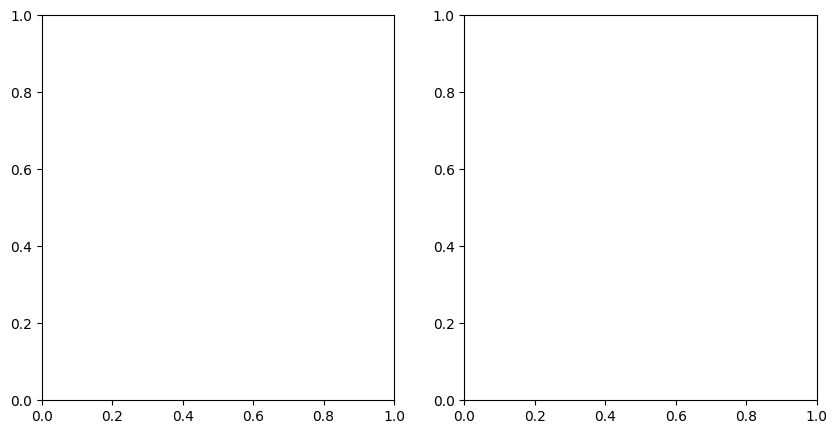

In [8]:
# Define the inverse transformation function
inv_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    transforms.Normalize(mean=(-1 * np.array(mean) / np.array(std)).tolist(),std=(1 / np.array(std)).tolist(),),
    transforms.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

# Apply the inverse transformation to the transformed image tensor
original_images = inv_transform(images)
original_images = original_images.numpy()

# Plot the original images
plt.figure(figsize=(10, 5))
for i in range(original_images.shape[0]):
    plt.subplot(1, original_images.shape[0], i + 1)
    # plt.imshow(original_images[i])
    # plt.axis('off')
    # plt.title(f'Image {i + 1}')
# plt.show()

In [9]:
# output = predict(images)
# print(output)

# thresholds = [0.5]*num_labels
# outputs = output.detach().cpu().numpy()
# outputs_thresholded = (outputs > thresholds).astype(np.int32)
# print(outputs_thresholded)

# acc_list, spec_list = [], []
# labels_true = labels.detach().cpu().numpy().astype(np.int32)
# for label_index in range(labels.shape[1]):
#     label_true = labels_true[:, label_index]
#     label_pred = outputs_thresholded[:, label_index]

#     # Check if label_true and label_pred contain only one unique value
#     if len(set(label_true)) == 1 and len(set(label_pred)) == 1:
#         acc = accuracy_score(label_true, label_pred)
#         spec = 0.0  # Set specificity to 0 when there's only one class present
#     else:
#         acc = accuracy_score(label_true, label_pred)
#         tn, fp, _, _ = confusion_matrix(label_true, label_pred).ravel()
#         spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0

#     acc_list.append(acc)
#     spec_list.append(spec)

# print(acc_list,"\n", spec_list)

In [10]:
print(images[i].unsqueeze(0).shape)

torch.Size([1, 384, 384, 3])


In [11]:
target_layer_dn = densenet.backbone.features.denseblock4.denselayer32.conv2
target_layer_rn = resnet.backbone.features.layer4[-1].conv3 

def grad_cam(model, target_layer, inputs, class_id):
    # Register a hook on the target layer to get its output
    output_cache = []
    def get_target_output(module, input, output):
        output_cache.append(output.detach())
    handle = target_layer.register_forward_hook(get_target_output)

    # Compute the output of the model
    model.zero_grad()
    output = model(inputs)

    # Get the predicted score for the specified class
    pred_score = output[:, class_id].sum()

    # Backpropagate to compute gradients
    pred_score.backward(retain_graph=True)

    # Get the gradients of the target layer output
    gradients = target_layer.weight.grad

    # Remove the hook
    handle.remove()

    # Compute importance weights (attention scores)
    importance_weights = gradients.mean(dim=(2, 3), keepdim=True)
    output_cache[0]= output_cache[0].permute(1,0,2,3)
    dim = output_cache[0].size(0)
    dim = output_cache[0].size(0)
    print(importance_weights.shape, output_cache[0].shape)
    
    output_cache[0]= output_cache[0].reshape(dim, -1, 1, 1)[:,:importance_weights.size(1),:,:] 
    print(importance_weights.shape, output_cache[0].shape)

    # Generate Grad-CAM heatmap
    cam = (importance_weights * output_cache[0]).sum(dim=2)

    return cam


# Define the predict function with Grad-CAM
def predict_with_gradcam(x):
    tmp = torch.tensor(x).to(device)
    tmp = tmp.permute(0, 3, 1, 2)

    # Forward pass for both models
    outputs1 = densenet(tmp)
    outputs2 = resnet(tmp)

    # Compute the ensemble output
    output = 0.6 * outputs1 + 0.4 * outputs2

    # Get the predicted class ID (assuming binary classification)
    class_id = 0

    # Compute Grad-CAM for both models
    cam_dn = grad_cam(densenet, target_layer_dn, tmp, class_id)
    # cam_rn = grad_cam(resnet, target_layer_rn, tmp, class_id)
    cam_rn = None

    return torch.sigmoid(output), cam_dn, cam_rn

# Example usage:
output, cam_dn, cam_rn = predict_with_gradcam(images)

print("Output:", output)
print("Grad-CAM (DenseNet):", cam_dn)
print("Grad-CAM (ResNet):", cam_rn)

/tmp/ipykernel_3029980/3576555610.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.tensor(x).to(device)


KeyboardInterrupt: 

In [ ]:
# Normalize the Grad-CAM values to be between 0 and 1
cam_dn_normalized = cam_dn - cam_dn.min()
cam_dn_normalized = cam_dn_normalized / (cam_dn_normalized.max() - cam_dn_normalized.min())

# Convert the tensor to a numpy array
cam_dn_numpy = cam_dn_normalized.detach().numpy()

# Get the batch size, height, and width
batch_size, height, width = cam_dn_numpy.shape

# Resize the Grad-CAM heatmap to match the original image size
cam_dn_resized = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        cam_dn_resized[i, j] = cam_dn_numpy[0, i, j]

# Plot the Grad-CAM heatmap
plt.imshow(cam_dn_resized, cmap='jet')
plt.axis('off')
plt.show()


In [ ]:
for i in range(images.shape[0]):
    apply_grad_cam(densenet, images[i].unsqueeze(0).permute(0, 3, 1, 2), class_idx=0, target_layer=target_layer_dn)  # Example for class index 0
    apply_grad_cam(resnet, images[i].unsqueeze(0).permute(0, 3, 1, 2), class_idx=0, target_layer=target_layer_rn)  # Example for class index 0

RuntimeError: Given groups=1, weight of size [32, 128, 3, 3], expected input[1, 3, 384, 384] to have 128 channels, but got 3 channels instead

In [ ]:
def save_grad_cam_image(heatmap, image, filename):
    superimposed_img = heatmap + np.float32(image.squeeze().permute(1, 2, 0).cpu().numpy())
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

for i in range(images.shape[0]):
    grad_cam_heatmap_dn = apply_grad_cam(densenet, images[i].unsqueeze(0), class_idx=0, target_layer=target_layer_dn)
    grad_cam_heatmap_rn = apply_grad_cam(resnet, images[i].unsqueeze(0), class_idx=0, target_layer=target_layer_rn)
    
    save_grad_cam_image(grad_cam_heatmap_dn, images[i], f'./gradcam/misc/densenet_image_{i}.png')
    save_grad_cam_image(grad_cam_heatmap_rn, images[i], f'./gradcam/misc/resnet_image_{i}.png')


In [ ]:
with open(filename2, 'w') as f:
    for i in range(len(idx)):
        sorted_output = torch.sort(output[i], descending=True)
        top_preds = np.array(sorted_output[0][:4].detach().cpu().numpy())
        top_indices = sorted_output[1][:4].cpu().numpy()
        formatted_preds = ', '.join([f'{pred:.4f}' for pred in top_preds])
        pred_classes = top_preds > 0.5
        top_classes = np.where(labels[i] == 1)[0]

        print(f'Image No. {idx[i]}, Image name {image_names[i]}:\nTop Predictions: {formatted_preds}\nTop Class IDs: {top_indices}'
              f'\nTop Class Names: {[class_names[idx] for idx in top_indices]}\nPredicted Classes: {[class_names[idx] for idx in top_indices[pred_classes]]}'
              f'\nTrue Classes: {[class_names[idx] for idx in top_classes]}\n')

        f.write(f'Image No. {idx[i]}:\n')
        f.write(f'Image names {image_names[i]}:\n')
        f.write(f'Top Predictions: {formatted_preds}\n')
        f.write(f'Top Class IDs: {top_indices}\n')
        f.write(f'Top Class Names: {[class_names[idx] for idx in top_indices]}\n')
        f.write(f'Predicted Classes: {[class_names[idx] for idx in top_indices[pred_classes]]}\n')
        f.write(f'True Classes: {[class_names[idx] for idx in top_classes]}\n\n')

    f.write('Thresholds:\n')
    f.write('\n'.join(map(str, threshold)) + '\n')

    f.write('\nClass Names:\n')
    f.write('\n'.join(class_names) + '\n')
